# Setup

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
import pandas as pd


sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'bravesouls/word2vec/comment'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
sagemaker-us-east-1-023375022819


In [2]:
def prep_data():
    !mkdir Data
    !aws s3 cp s3://aws-ml-chicago-team-bravesouls/amazon_review_polarity_csv.tgz Data
    !tar -xvzf Data/amazon_review_polarity_csv.tgz
#prep_data()

In [8]:
#!head -100000 amazon_review_polarity_csv/train.csv > amazon_review_polarity_csv/train_100k.csv

# Data Processing

In [3]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def transform_instance(row):
    cur_row = []
    cur_row.extend(nltk.word_tokenize(row[1].lower()+ ' ' + row[2].lower()))
    return cur_row

In [6]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    #shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [51]:
def createInputFileForW2V(input_file, output_file):
    !awk -F "\"*,\"*" '{print $3}' $input_file > "$output_file"

In [52]:
%%time
# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 20% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
preprocess('amazon_review_polarity_csv/train.csv', 'amazon_review_polarity_w2v.train', keep=.5)
#createInputFileForW2V('amazon_review_polarity_csv/train.csv', 'amazon_review_polarity_w2v.train')

CPU times: user 1min 2s, sys: 11.1 s, total: 1min 13s
Wall time: 4min 54s


In [53]:
%%time

train_channel = prefix + '/train'

sess.upload_data(path='amazon_review_polarity_w2v.train', bucket=bucket, key_prefix=train_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)

CPU times: user 4.34 s, sys: 3.45 s, total: 7.79 s
Wall time: 4.26 s


In [54]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [55]:
region_name = boto3.Session().region_name

In [56]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [57]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         base_job_name= "Gaj-BraveSouls-W2V",
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [58]:
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

In [59]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

In [60]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: Gaj-BraveSouls-W2V-2019-01-09-19-26-55-787


2019-01-09 19:26:55 Starting - Starting the training job...
2019-01-09 19:26:58 Starting - Launching requested ML instances......
2019-01-09 19:28:04 Starting - Preparing the instances for training...
2019-01-09 19:28:49 Downloading - Downloading input data...
2019-01-09 19:29:15 Training - Training image download completed. Training in progress.
Arguments: train
[01/09/2019 19:29:16 WARNING 139813246289728] Loggers have already been setup.
[01/09/2019 19:29:16 WARNING 139813246289728] Loggers have already been setup.
[01/09/2019 19:29:16 INFO 139813246289728] nvidia-smi took: 0.0252051353455 secs to identify 0 gpus
[01/09/2019 19:29:16 INFO 139813246289728] Running single machine CPU BlazingText training using batch_skipgram mode.
[01/09/2019 19:29:16 INFO 139813246289728] 2 files found in train channel. Using /opt/ml/input/data/train/amazon_review_polarity_w2v.train for training...
[01/09/2019 19:29:16 INFO 139813246289728] Processing /opt/ml/input/data/train/amazon_review_polarity_w

In [62]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-01-09-19-35-29-880
INFO:sagemaker:Creating endpoint with name Gaj-BraveSouls-W2V-2019-01-09-19-26-55-787


---------------------------------------------------------------------------!

In [63]:
words = ["awesome", "blazing", "sucks", "cool"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs = json.loads(response)
print(vecs)

[{'vector': [0.4336329698562622, 0.29507043957710266, -0.20025750994682312, 0.03641125559806824, 0.11803875863552094, -0.1918765753507614, -0.10744990408420563, -0.11664986610412598, 0.02750803530216217, -0.07860443741083145, 0.0662948489189148, 0.029793687164783478, -0.2588196396827698, 0.18066881597042084, 0.1541680246591568, 0.3168652057647705, -0.08074073493480682, 0.4959176480770111, -0.14176788926124573, 0.04589884728193283, -0.03178638592362404, -0.04349641501903534, -0.216635599732399, -0.02185872569680214, 0.12109643220901489, 0.5141950249671936, 0.3449277877807617, -0.22923950850963593, -0.0899171233177185, 0.13248993456363678, -0.2322874814271927, -0.02754480019211769, 0.013069829903542995, -0.25666189193725586, -0.2595095932483673, -0.13359281420707703, -0.17958837747573853, 0.3637378215789795, 0.002554513979703188, -0.3927582800388336, -0.11588119715452194, 0.1963510662317276, -0.34804680943489075, 0.0963960513472557, 0.3902956247329712, -0.015896275639533997, -0.251417368

In [64]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [65]:
!tar -xvzf model.tar.gz

eval.json
vectors.txt
vectors.bin


In [66]:
!cat eval.json


{
    "EN-WS-353-ALL.txt": {
        "not_found": 1, 
        "spearmans_rho": 0.6314934539924102, 
        "total_pairs": 353
    }, 
    "EN-WS-353-REL.txt": {
        "not_found": 0, 
        "spearmans_rho": 0.5877750371552062, 
        "total_pairs": 252
    }, 
    "EN-WS-353-SIM.txt": {
        "not_found": 1, 
        "spearmans_rho": 0.699779638814217, 
        "total_pairs": 203
    }, 
    "mean_rho": 0.6396827099872778
}

In [67]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

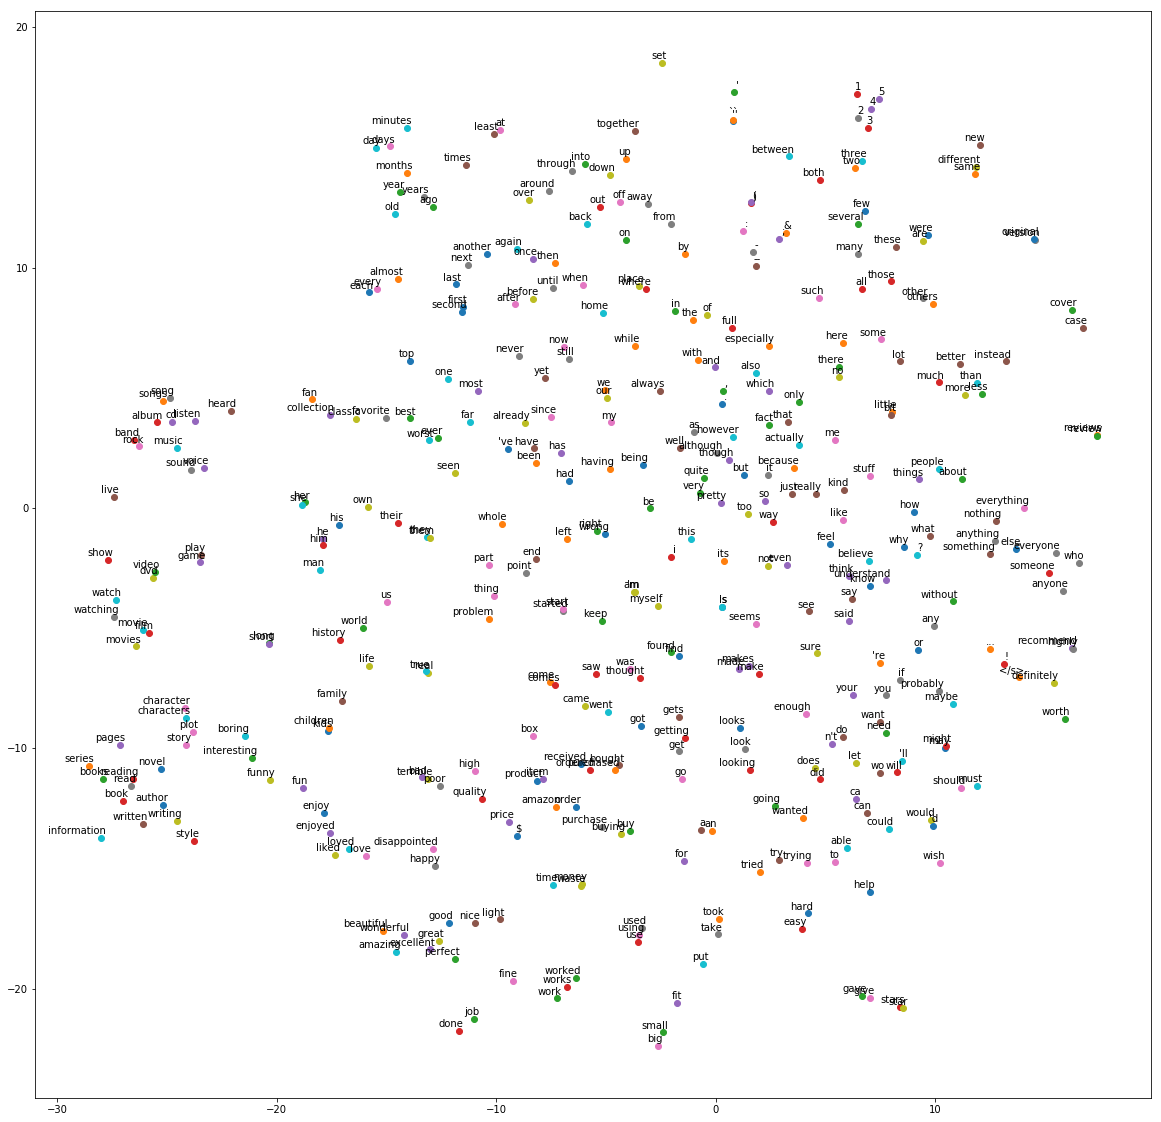

In [22]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

In [68]:
sess.delete_endpoint(bt_endpoint.endpoint)

INFO:sagemaker:Deleting endpoint with name: Gaj-BraveSouls-W2V-2019-01-09-19-26-55-787
